<font color="grey">
    
# Outline:

- 1. Prepare text data
- 2. Vector search
- 3. Text classification
- 4. Setiment analysis
- 5. Gradio dashboard
</font>

<font color="grey">

### Download the data from: https://www.kaggle.com/datasets/dylanjcastillo/7k-books-with-metadata
</font>

In [3]:
import pandas as pd
df=pd.read_csv(r'F:\learning\LLM\data\books.csv')

<font color="grey">
Or using following method which can download the data automatically to your computer for you.

In [ ]:
import kagglehub
# Download latest version
path = kagglehub.dataset_download("dylanjcastillo/7k-books-with-metadata")
print("Path to dataset files:", path)
df=pd.read_csv(f"{path}/books.csv")

import shutil
shutil.rmtree(r'C:\Users\li\.cache\kagglehub')

In [6]:
df.head()

,isbn13,isbn10,title,subtitle,authors,categories,thumbnail,description,published_year,average_rating,num_pages,ratings_count
0,9780002005883,0002005883,Gilead,NaN,Marilynne Robinson,Fiction,http://books.google.com/books/content?id=KQZCP...,A NOVEL THAT READERS and critics have been eag...,2004.0,3.85,247.0,361.0
1,9780002261982,0002261987,Spider's Web,A Novel,Charles Osborne;Agatha Christie,Detective and mystery stories,http://books.google.com/books/content?id=gA5GP...,A new 'Christie for Christmas' -- a full-lengt...,2000.0,3.83,241.0,5164.0
2,9780006163831,0006163831,The One Tree,NaN,Stephen R. Donaldson,American fiction,http://books.google.com/books/content?id=OmQaw...,Volume Two of Stephen Donaldson's acclaimed se...,1982.0,3.97,479.0,172.0
3,9780006178736,0006178731,Rage of angels,NaN,Sidney Sheldon,Fiction,http://books.google.com/books/content?id=FKo2T...,"A memorable, mesmerizing heroine Jennifer -- b...",1993.0,3.93,512.0,29532.0
4,9780006280897,0006280897,The Four Loves,NaN,Clive Staples Lewis,Christian life,http://books.google.com/books/content?id=XhQ5X...,Lewis' work on the nature of love divides love...,2002.0,4.15,170.0,33684.0


In [9]:
df.columns

Index(['isbn13', 'isbn10', 'title', 'subtitle', 'authors', 'categories',
       'thumbnail', 'description', 'published_year', 'average_rating',
       'num_pages', 'ratings_count'],
      dtype='object')

<font color="grey">
    
### Check the missing values for each feature
</font>

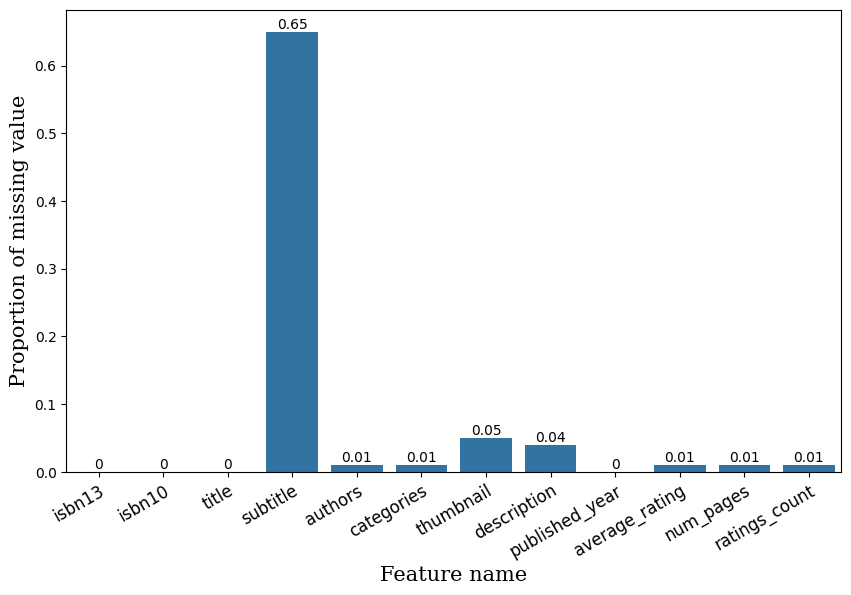

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_fig(feature_name,values):
    dff=pd.DataFrame({"name":feature_name, 'value':values})
    plt.figure(figsize=(10, 6))
    ax=sns.barplot(dff,x='name',y='value')
    plt.xticks(rotation=30,ha='right', rotation_mode='anchor',fontsize=12)
    plt.xlabel("Feature name",fontdict= {'family':'serif','size':15})
    plt.ylabel("Proportion of missing value",fontdict= {'family':'serif','size':15})
    for container in ax.containers:
        ax.bar_label(container)
    plt.show()
feature_name=list(df.columns)
values=((df.isna().sum(axis=0)/len(df)).apply(lambda x: round(x,2))).values
plot_fig(feature_name,values)

<font color="grey">
    
- We can see feature subtitle contains a lot of missing values.
- Feature description also contain some missing values.
</font>

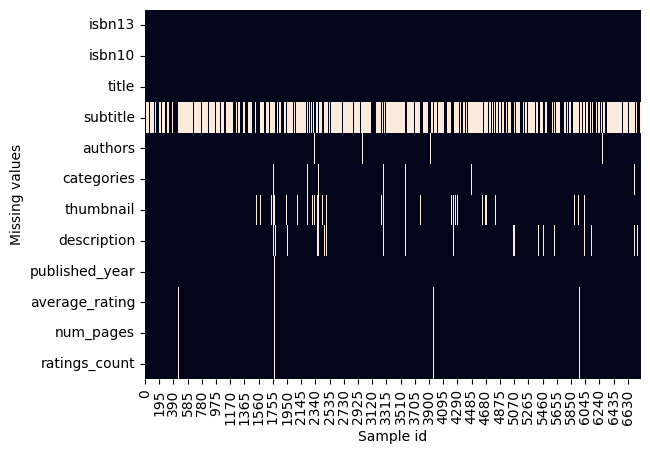

In [11]:
ax = plt.axes()
sns.heatmap(df.isna().transpose(), cbar=False, ax=ax)
plt.xlabel("Sample id")
plt.ylabel("Missing values")
plt.show() 

<font color="grey">
    
- This heatmap highlights where values are missing in the dataset. It shows that **average_rating**, **num_pages**, and **ratings_count** have missing values at the same positions, suggesting that these data points may have been collected differently or originate from a separate source.
</font>

<font color="grey">
    
Explore if the missing value in *description* is related with other features, such as *num_pages*.
</font>

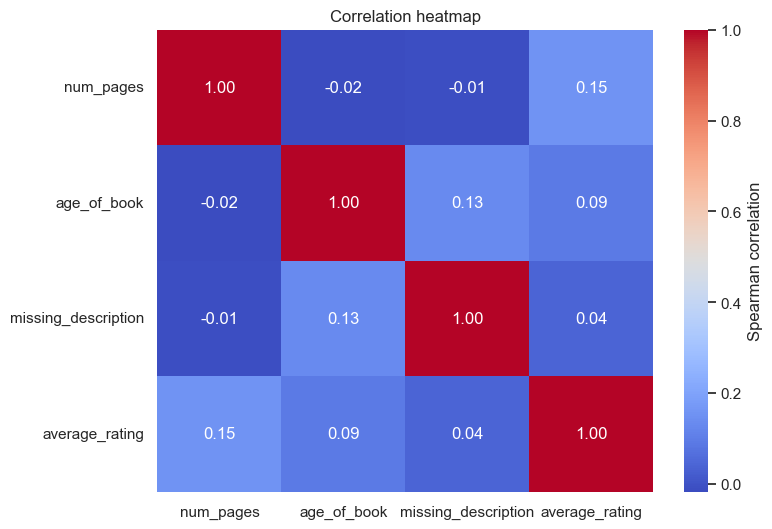

In [14]:
import numpy as np
df['missing_description']=np.where(df['description'].isna(),1,0)
df['age_of_book']=2026-df['published_year']
columns_of_interest = ["num_pages", "age_of_book", "missing_description", "average_rating"]
correlation_matrix = df[columns_of_interest].corr(method = "spearman")
sns.set_theme(style="white")
plt.figure(figsize=(8, 6))
heatmap = sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar_kws={"label": "Spearman correlation"})
heatmap.set_title("Correlation heatmap")
plt.show()

<font color="grey">
    
- The correlation is not very high.
</font>

<font color="grey">
    
### Remove books with missing values.
</font>

In [16]:
df = df[~(df["description"].isna()) & ~(df["num_pages"].isna()) & ~(df["average_rating"].isna()) &  ~(df["published_year"].isna())]

In [17]:
df["categories"].value_counts().reset_index().sort_values("count", ascending=False)

,categories,count
0,Fiction,2523
1,Juvenile Fiction,534
2,Biography & Autobiography,391
3,History,258
4,Literary Criticism,164
...,...,...
519,Aeronautics,1
518,Childbirth,1
517,Consumer behavior,1
516,Seduction,1


<font color="grey">
    
- There are a lot of book categories.
</font>

<Axes: xlabel='words_in_description', ylabel='Density'>

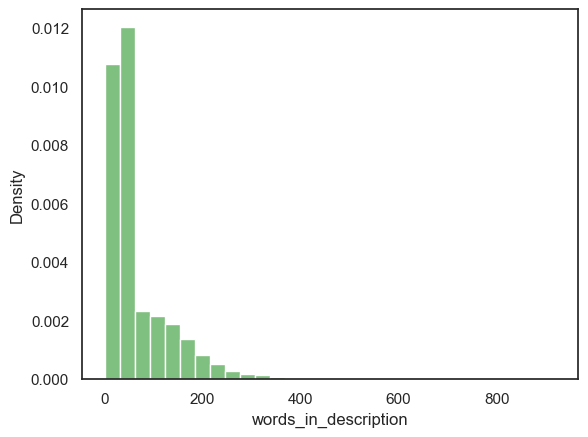

In [19]:
# The world length in description
df["words_in_description"]=df["description"].apply(lambda x: len(x.split()))
sns.histplot( df["words_in_description"], kde=False,bins=30, color='green', stat="density", alpha=.5)

In [20]:
df.loc[df["words_in_description"].between(1, 4), "description"]

6                                           Donation.
11                                     Fantasy-roman.
748              Includes bibliographical references.
770                             Bound For Oregon (PB)
775                                No Marketing Blurb
812                                No Marketing Blurb
857                          First published in 1813.
944                         Edited by Maurice Hindle.
953                        DEFOE/ROBINSON CRUSOE (BC)
954                             Edited by John Carey.
962                         ALLEN/GETTING THINGS DONE
1054                            GILBERT/EAT PRAY LOVE
1056    "Graham Greene centennial, 1904-2004"--Cover.
1060                   STEINBECK/GRAPES OF WRATH (BC)
1346                                   Fantasy-roman.
1546                                      Winter 2003
1610                                      Winter 1999
1813                             National bestseller.
1981                        

<font color="grey">
Books with very short descriptions are not useful for sentiment analysis or text classification and should therefore be removed.
</font>

In [21]:
df = df[df["words_in_description"] >= 25]

In [22]:
# Merge title and subtitle
df["title_and_subtitle"] =np.where(df['subtitle'].isna(),df['title'],df['subtitle']+": "+ df['title'])

In [23]:
# Merge isbn13 and description
df["tagged_description"] = df[["isbn13", "description"]].astype(str).agg(" ".join, axis=1)

In [24]:
# Drop features that we are not interested
df.drop(["subtitle", "missing_description", "age_of_book", "words_in_description"], axis=1, inplace=True)

In [26]:
df.columns

Index(['isbn13', 'isbn10', 'title', 'authors', 'categories', 'thumbnail',
       'description', 'published_year', 'average_rating', 'num_pages',
       'ratings_count', 'title_and_subtitle', 'tagged_description'],
      dtype='object')

In [27]:
df.to_csv(r"F:\learning\LLM\data\books_cleaned.csv", index = False)

<font color="grey">
    
## The whole code: 
</font>

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
df=pd.read_csv(r'F:\learning\LLM\data\books.csv')

# Or get the data using follow method:
def another_way_get_data():
    import kagglehub
    import shutil
    path = kagglehub.dataset_download("dylanjcastillo/7k-books-with-metadata")
    print("Path to dataset files:", path)
    df=pd.read_csv(f"{path}/books.csv")
    shutil.rmtree(r'C:\Users\li\.cache\kagglehub')
    return df

def plot_missing(df):
    # Check the missing values
    def plot_fig(feature_name,values):
        dff=pd.DataFrame({"name":feature_name, 'value':values})
        plt.figure(figsize=(10, 6))
        ax=sns.barplot(dff,x='name',y='value')
        plt.xticks(rotation=30,ha='right', rotation_mode='anchor',fontsize=12)
        plt.xlabel("Feature name",fontdict= {'family':'serif','size':15})
        plt.ylabel("Proportion of missing value",fontdict= {'family':'serif','size':15})
        for container in ax.containers:
            ax.bar_label(container)
        plt.show()
    feature_name=list(df.columns)
    values=((df.isna().sum(axis=0)/len(df)).apply(lambda x: round(x,2))).values
    plot_fig(feature_name,values)
    
    ax = plt.axes()
    sns.heatmap(df.isna().transpose(), cbar=False, ax=ax)
    plt.xlabel("Sample id")
    plt.ylabel("Missing values")
    plt.show() 
plot_missing(df)

df['missing_description']=np.where(df['description'].isna(),1,0)
df['age_of_book']=2026-df['published_year']

columns_of_interest = ["num_pages", "age_of_book", "missing_description", "average_rating"]
correlation_matrix = df[columns_of_interest].corr(method = "spearman")
sns.set_theme(style="white")
plt.figure(figsize=(8, 6))
heatmap = sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar_kws={"label": "Spearman correlation"})
heatmap.set_title("Correlation heatmap")
plt.show()

# Remove missing value
df = df[~(df["description"].isna()) & ~(df["num_pages"].isna()) & ~(df["average_rating"].isna()) & ~(df["published_year"].isna())]

print('categories information: ')
print(df["categories"].value_counts().reset_index().sort_values("count", ascending=False))

df["words_in_description"]=df["description"].apply(lambda x: len(x.split()))
sns.histplot( df["words_in_description"], kde=False,bins=30, color='green', stat="density", alpha=.5)

print('Book description whose length is between 1 and 4: ')
print(df.loc[df["words_in_description"].between(1, 4), "description"])

df = df[df["words_in_description"] >= 25]
df["title_and_subtitle"] =np.where(df['subtitle'].isna(),df['title'],df['subtitle']+": "+ df['title'])

# Merge isbn13 and description
df["tagged_description"] = df[["isbn13", "description"]].astype(str).agg(" ".join, axis=1)

# Drop features that we are not interested
df.drop(["subtitle", "missing_description", "age_of_book", "words_in_description"], axis=1, inplace=True)
df.to_csv(r"F:\learning\LLM\data\books_cleaned.csv", index = False) 